# Applied Machine Learning Final Notebook

### by Avery Pike, Will Antink, Tyler Gomez Riddick, & Jerry McGlade

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import k_means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

In [2]:
mlb = pd.read_csv('slimStats.csv')
mlbNorm = pd.read_csv('mlbNorm.csv')

## K Means Clustering

We had two main areas that we wanted to find threshold values for: population and wins. The best way to facilitate this process is with univariate clustering around those two features. We took an unsupervised learning approach because we wanted to determine the best way for teams to be separated by wins and by populations. We then used these values to assist with linear regression.

In [3]:
mlb = pd.read_csv('slimStats.csv')
mlb.head(5)
mlb['popMil'] = mlb['Population']/1000000 # Reducing the population to in millions

In [4]:
mlbPop = mlb.loc[:,['popMil']] # Selecting just the population column
mlbWins = mlb.loc[:,['W']] # Selecting just the wins column

### Choosing the Right Number of Clusters

There were two main methods we used when trying to determine how many clusters we should use for each of the univariate clustering models we ran. These methods are the elbow method and the silhouette score.

#### The Elbow Method

The Elbow Method is the easier of the two methods. It simpler computes the within-cluster-sum-of-square (WCSS) value, which is just the sum of the squared distance from each point in the cluster to its centroid. This value is calculated for multiple numbers of clusters and then graphed. The "elbow" part of the elbow method refers to the point on the graph with a significant "elbow", or where the WCSS levels out for the first time. We did this for each of the clusters to see if we could determine an optimal cluster number.

C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

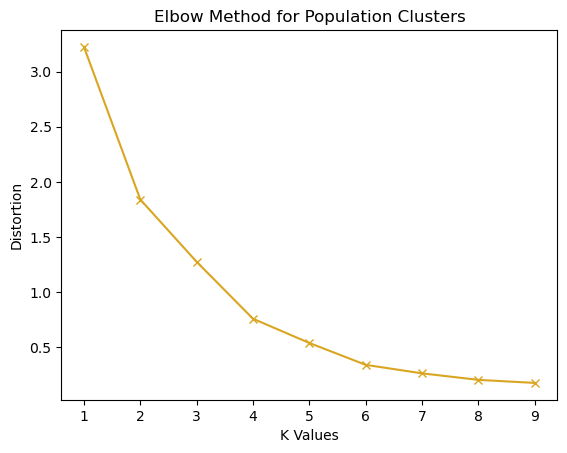

<Figure size 640x480 with 0 Axes>

In [5]:
distortionsPop = []
inertiasPop = []
mapping1Pop = {}
mapping2Pop = {}
K = range(1,10)
XPop = mlbPop

for k in K:
    kmeanModel = KMeans(n_clusters = k,n_init=30).fit(XPop)
    kmeanModel.fit(XPop)

    distortionsPop.append(sum(np.min(cdist(XPop, kmeanModel.cluster_centers_, 'euclidean'),
                                    axis = 1)) / XPop.shape[0])
    inertiasPop.append(kmeanModel.inertia_)
    mapping1Pop[k] = sum(np.min(cdist(XPop, kmeanModel.cluster_centers_,
                                    'euclidean'), axis=1)) / XPop.shape[0]
    mapping2Pop[k] = kmeanModel.inertia_

plt.plot(K, distortionsPop, 'x-',color = 'goldenrod')
plt.xlabel('K Values')
plt.ylabel('Distortion')
plt.title('Elbow Method for Population Clusters')
plt.show()
plt.savefig('elbow-pop.png')

C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

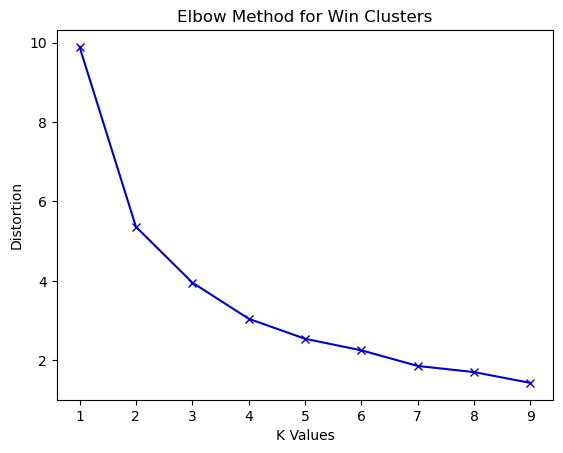

In [6]:
distortionsWins = []
inertiasWins = []
mapping1Wins = {}
mapping2Wins = {}
K = range(1,10)
XWins = mlbWins

for k in K:
    kmeanModel = KMeans(n_clusters = k,n_init=30).fit(XWins)
    kmeanModel.fit(XWins)

    distortionsWins.append(sum(np.min(cdist(XWins, kmeanModel.cluster_centers_, 'euclidean'),
                                    axis = 1)) / XWins.shape[0])
    inertiasWins.append(kmeanModel.inertia_)
    mapping1Wins[k] = sum(np.min(cdist(XWins, kmeanModel.cluster_centers_,
                                    'euclidean'), axis=1)) / XWins.shape[0]
    mapping2Wins[k] = kmeanModel.inertia_

plt.plot(K, distortionsWins, 'x-',color='mediumblue')
plt.xlabel('K Values')
plt.ylabel('Distortion')
plt.title('Elbow Method for Win Clusters')
plt.show()

In both cases, it is difficult to identify a good "elbow", so we should utilize the other method.

#### Silhouette Score

The Silhouette Score is another way of measuring cluster suitability. It should be noted that this method is most effective for clusters that are convex in shape, which ours are not, but we can use it as a rough guideline. The Silhouette score is a value between $-1$ and $1$, with a value of $1$ indicating the clusters are well defined and far apart, and a value of $-1$ indicating that the clusters are assigned incorrectly. The code for the silhouette scores for the population and win data is below.

C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

Text(0.5, 1.0, 'Silhouette Score v Number of Clusters for Population')

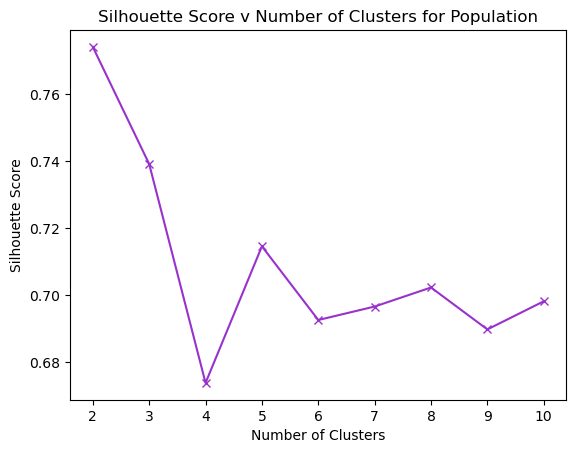

In [7]:
sil = []
ks = []
kmax = 10

for k in range(2, kmax+1):
    ks.append(k)
    kmeans = KMeans(n_clusters = k,n_init=30).fit(mlbPop)
    labels = kmeans.labels_
    sil.append(silhouette_score(mlbPop,labels,metric = 'euclidean'))
plt.plot(ks,sil,'x-',color='darkorchid')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score v Number of Clusters for Population')

C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

Text(0.5, 1.0, 'Silhouette Score v Number of Clusters')

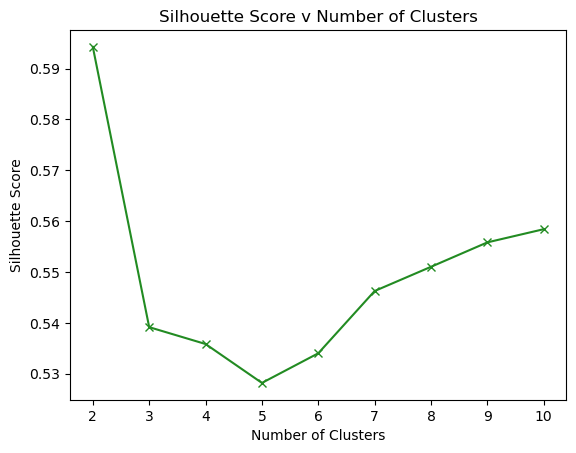

In [8]:
silW = []
ksW = []
kmax = 10

for k in range(2, kmax+1):
    ksW.append(k)
    kmeans = KMeans(n_clusters = k,n_init=30).fit(mlbWins)
    labels = kmeans.labels_
    silW.append(silhouette_score(mlbWins,labels,metric = 'euclidean'))
plt.plot(ksW,silW,'x-',color='forestgreen')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score v Number of Clusters')

In [9]:
centroidP,labelP,inertiaP = k_means(
    mlbPop,n_clusters = 5,n_init=30
)
print('The inertia of the population clustering is',round(inertiaP,2))
mlb['popLabel']=labelP

C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


The inertia of the population clustering is 215.67


In [10]:
centroidW,labelW,inertiaW = k_means(
    mlbWins,n_clusters = 7,n_init=30
)
print('The inertia of the win ratio clustering is', round(inertiaW,2))
mlb['winLabel']=labelW

C:\Users\tyler\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


The inertia of the win ratio clustering is 2616.95


Looking at the silhouette score for these clustering methods reveals that the best number of clusters is probably 2 to 3. For population, however, we can see that there is a local maximum at 5 clusters, which admittedly is smaller than 2 or 3 clusters, but because we are just trying to define thresholds based on these variables with univariate clusters, 5 population clusters is appropriate. We can see the same situation for the win clusters. Because 7 is a local max, we chose that as our cluster number for wins.

## Feature Scaling

The orders of magnitude of many of these variables vary greatly which can cause problems for our models, as large features (such as population) can weigh more heavily and obscure the impact of smaller features (such as wins). Thus, we had a need to scale our features so that they were all on the same level and could make principal component analysis and regression easier to accomplish.

We did feature scaling using Z-score standardization from sklearn's StandardScaler package. We also had to take the Time column from our slimStats dataset and turn it into a value we could actually use. Below is the code that extracts the time and also normalizes the numeric features.

In [11]:
mlb['Time'] = pd.to_datetime(mlb['Time'])
mlb['Time'] = mlb['Time'].dt.hour * 60 + mlb['Time'].dt.minute # Extracting hours and minutes

columns_to_normalize = ['W', 'L', 'R', 'RA', 'Rdiff', 'BatAge', 'PAge', '#a-tA-S',
                        'Time', 'HR', 'RTotal', 'SB', 'K.', 'ISO', 'AVG', 'OBP', 'wOBA', 'wRC.', 'WAR', 'Population']

mlbNorm = mlb.copy()

scaler = StandardScaler()
mlbNorm[columns_to_normalize] = scaler.fit_transform(mlbNorm[columns_to_normalize])
mlbNorm.head()

C:\Users\tyler\AppData\Local\Temp\ipykernel_14300\4081412354.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mlb['Time'] = pd.to_datetime(mlb['Time'])


,...1,Rk,Team,W,L,WL,R,RA,Rdiff,Home,...,AVG,OBP,wOBA,wRC.,WAR,city.x,Population,popMil,popLabel,winLabel
0,0,1,Atlanta Braves,1.930031,-1.932452,0.642,2.705746,-0.163182,1.976805,52-29,...,1.629306,1.544911,2.748627,3.158725,2.720849,Atlanta,0.150683,6.106,1,3
1,1,2,Baltimore Orioles,1.678438,-1.680243,0.623,1.061259,-0.542328,1.130906,49-32,...,-0.024562,-0.137942,0.103222,0.974039,0.642624,Baltimore,-0.683957,2.355,3,3
2,2,3,Los Angeles Dodgers,1.594574,-1.596173,0.617,2.294624,-0.352755,1.835822,53-28,...,0.197153,1.275999,1.514178,2.206908,1.703907,LosAngeles,1.580987,12.534,2,3
3,3,4,Tampa Bay Rays,1.510710,-1.512103,0.611,1.677942,-0.731901,1.694839,53-28,...,0.387084,0.638842,1.107314,2.392750,1.697797,Tampa,-0.545555,2.977,3,3
4,4,5,Milwaukee Brewers,0.923659,-0.923614,0.568,0.033454,-0.921474,0.707957,49-32,...,-1.207634,-0.244994,-0.698233,-0.561369,-0.105743,Milwaukee,-0.884217,1.455,3,2


## Principal Component Analysis

Our dataset has a lot of features, and a lot of those features have multicollinearity with other features in the dataset, making choosing the appropriate features and number of features difficult. We wanted to simplify our analysis and improve visualization by decomposing our high-dimensional baseball dataset into a single variable via principal component analysis. In order to determine this, we utilized a correlation matrix in conjunction with Avery's domain expertise to choose the best features. We only wanted to see correlation coefficients that were reasonably significant, which we determined to be $\geq 0.4$ or $\leq -0.4$.

<Axes: >

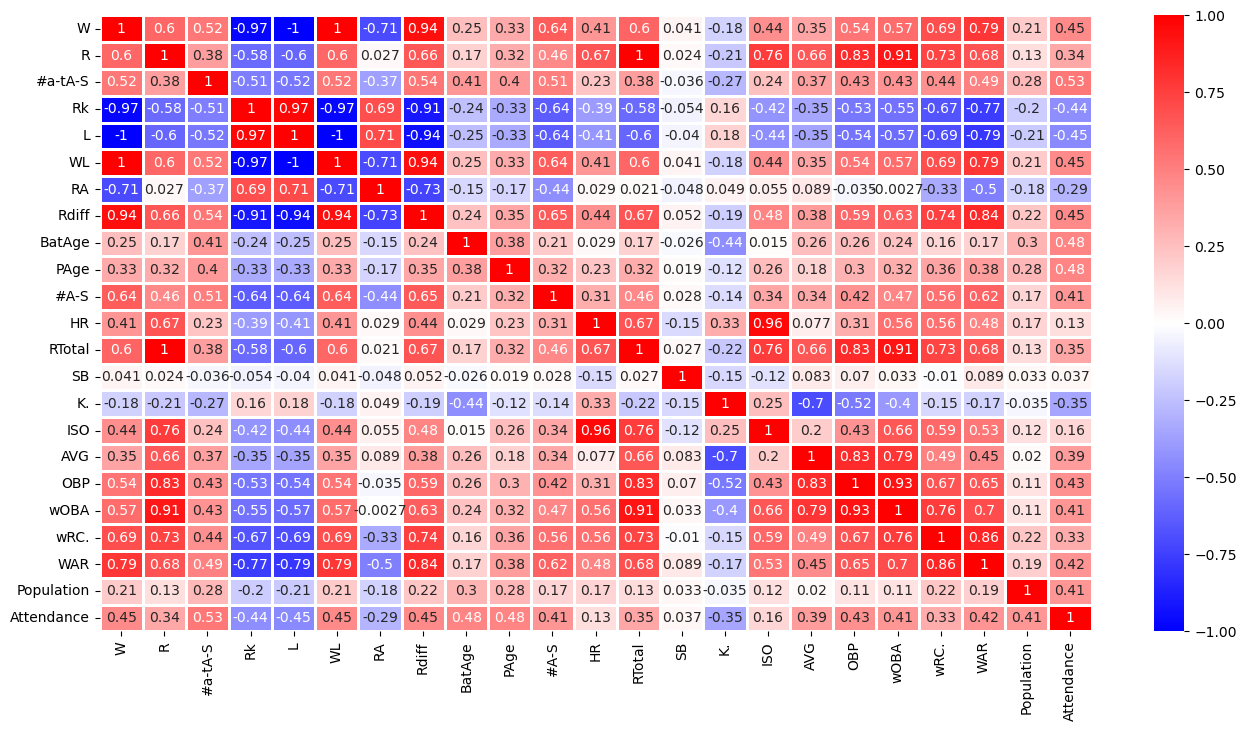

In [14]:
mlbNorm = pd.read_csv('mlbNorm.csv')

pd.set_option('display.max_rows', None)  # To display all rows
pd.set_option('display.max_columns', None)  # To display all columns

# Selecting all the numeric columns from the normalized MLB data
corrcol = mlbNorm.loc[:,['W','R','#a-tA-S','Rk','L','WL','RA','Rdiff','BatAge','PAge','#A-S','HR','RTotal','SB','K.','ISO','AVG','OBP','wOBA','wRC.','WAR','Population']]
corrcol = pd.concat([corrcol,mlb.loc[:,'Attendance']],axis=1) # Adding on the non-normalized attendance
cormat = corrcol.corr()
#cormat2 = cormat[cormat.abs() >= 0.4] # Just showing stats with an absolute value greater than or equal to 0.4
plt.figure(figsize=(16,8))
sns.heatmap(cormat,cmap='bwr',annot=True,linewidth=0.8,vmin=-1,vmax=1)

The important column here is the column on the far right, where attendance interacts with the other features. We chose the features with the most significant correlations: wins (W), all-time All-Stars (#a-tA-S), population, and batter's age.

We then performed PCA using these four features, decomposing them into a single principle component, from which we then performed regression using the standard sklearn linear regression package and the sklearn Support Vector Regression. The code cell below shows the fitting and transformation of the features and a plot of the principal component against actual attendance.

Text(0.5, 1.0, 'Attendance vs PCA (Wins, Population, All-Time All-Stars)')

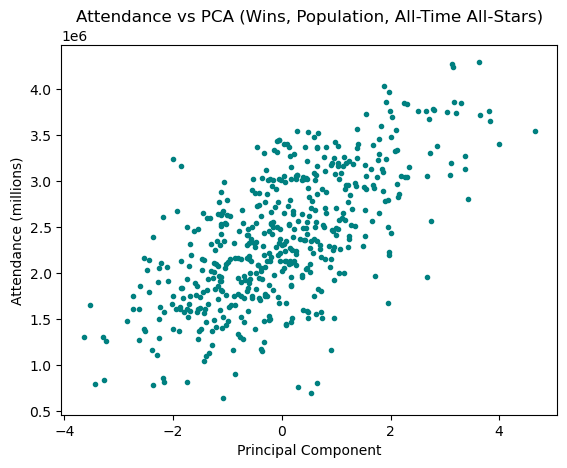

In [13]:
pca = PCA(n_components=1)
sst1 = mlbNorm.loc[:,['W','Population','#a-tA-S','BatAge']]
spca1 = pca.fit_transform(sst1)
pca.components_
plt.plot(spca1[:,0],mlb.loc[:,'Attendance'],'.',color='teal')
plt.xlabel('Principal Component')
plt.ylabel('Attendance (millions)')
plt.title('Attendance vs PCA (Wins, Population, All-Time All-Stars)')

## Linear Regression

We started by incorporating the principal component and our normalized attendance into a linear regression model. We used sklearn's linear regression package to accomplish this. As part of this process, we split our data into a 80/20 train test split and then trained the model on the training split. We calculated the $R^2$ value to determine how well our model explains the variance in our dataset. The code cell below is the code we used to accomplish this.

The R^2 value of this linear regression model is 0.436503141391689


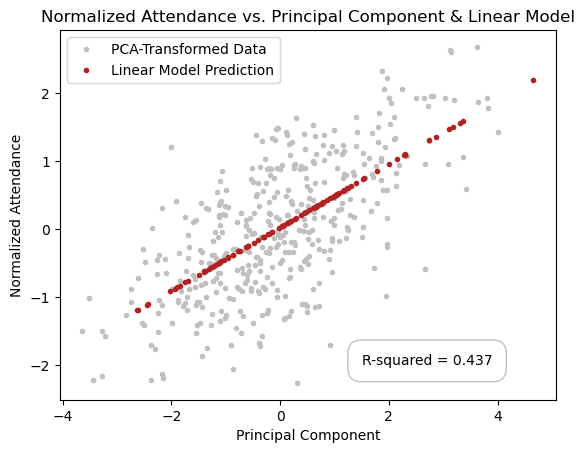

In [14]:
lr = LinearRegression()
lrdf = pd.DataFrame()
lrdf['PCA'] = spca1[:,0] # Calling the principal component model from the previous section
#lrdf['Attendance'] = slimStats.loc[:,'Attendance']
lrdf['Attendance'] = mlbNorm.loc[:,'Attendance']

Xl = lrdf['PCA']
yl = lrdf['Attendance']
Xl = Xl.values.reshape(-1,1)
Xl_train, Xl_test, yl_train, yl_test = train_test_split(Xl,yl,test_size=0.2,random_state=42)

lr.fit(Xl_train,yl_train)
yl_pred = lr.predict(Xl_test)
r2l = r2_score(yl_test,yl_pred)
print('The R^2 value of this linear regression model is',r2l)
plt.plot(Xl_train,yl_train,'.',color='silver',label = 'PCA-Transformed Data')
plt.plot(Xl_test,yl_pred,'.',color='firebrick',label='Linear Model Prediction')
plt.xlabel('Principal Component')
plt.ylabel('Normalized Attendance')
plt.title('Normalized Attendance vs. Principal Component & Linear Model')
plt.legend()
plt.text(1.5, -2, f'R-squared = {r2l:.3f}', fontsize=10, bbox=dict(facecolor='none', edgecolor='silver', boxstyle='round,pad=1'))
plt.savefig('linear-model.png')

The $R^2$ value of this linear regression model is about $0.437$. This is pretty good considering the sheer number of factors that play into the attendance a team gets any given season. However, we still want to see if we can do better. Enter Support Vector Regression.

## Support Vector Regression

We decided to pursue another regression model with support vector regression (SVR). We decided to pursue this avenue because of the increased flexibility of the model given that it allows us to imput a kernel and other hyperparameters. We chose to go with the radial basis function (RBF) as our primary kernel as it gives us additional flexibility with regard to multicollinearity. Multicollinearity is a concern due to the fact that all-time All-Stars and batter's age have some inter-variable correlation, but the RBF should help account for that.

We want to be sure to avoid overfitting, so we have to make sure that our C and gamma hyperparameters are tuned to the optimal values. To accomplish this, we wrote a function to fit an SVR model to our PCA data and normalized attendance, iterating over values for both C and gamma, and printing the model with the best $R^2$ value. The code cell below shows that function.

In [15]:
X = spca1 # This is our PCA
y = mlbNorm.loc[:,'Attendance'] # Normalized attendance
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42) # Splitting into train and test

def svrhyperrbf(x,y): # This function takes in the C and gamma values that it will iterate over
    list = [0,0,0]
    for i in range(x):
        for j in range(y):
            SVRtest = SVR(kernel = 'rbf', C=i+1, gamma = (j/100)) # C cannot be 0, so we have to start with 1
            SVRtest.fit(X_train, y_train)
            y_pred = SVRtest.predict(X_test)
            r2 = r2_score(y_test,y_pred)
            if r2 > list[0]:
                list[0] = r2
                list[1] = i+1
                list[2] = (j/100)
    print(list)

In [23]:
svrhyperrbf(101,101)

[0.44905983643427494, 1, 0.04]


The best $R^2$ value has hyperparameters of $C=1$ and $\gamma=0.04$. These are the ones we will use when constructing our final model.

The R2 score is 0.4490598364342758
The Mean-Squared-Error is 0.6164294921893235
The Mean Absolute Error is 0.5950355392093075
The Mean Absolute Percentage Error is 1.2133908823358543


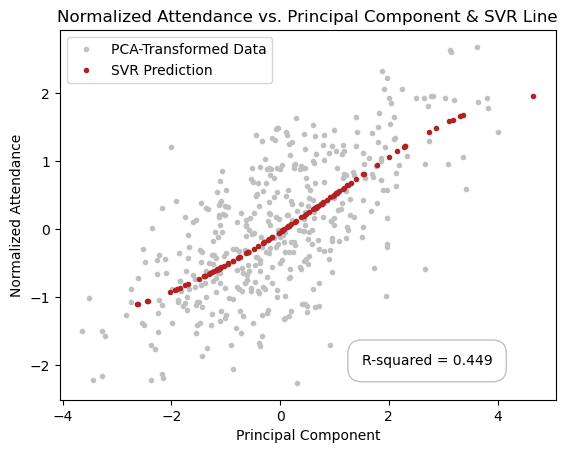

In [16]:
# Building the model using the above hyperparameters
SVR1 = SVR(kernel = "rbf", C=1, gamma=0.04)

SVR1.fit(X_train, y_train) # Using the same pre-defined X_train and y_train

y_pred = SVR1.predict(X_test)
r2score = r2_score(y_test,y_pred)
plt.plot(X_train,y_train,'.',color='silver',label = 'PCA-Transformed Data')
plt.plot(X_test,y_pred,'.',color='firebrick',label='SVR Prediction')
plt.xlabel('Principal Component')
plt.ylabel('Normalized Attendance')
plt.title('Normalized Attendance vs. Principal Component & SVR Line')
plt.legend()
plt.text(1.5, -2, f'R-squared = {r2score:.3f}', fontsize=10, bbox=dict(facecolor='none', edgecolor='silver', boxstyle='round,pad=1'))

print('The R2 score is', r2_score(y_test,y_pred))
print('The Mean-Squared-Error is', mean_squared_error(y_test,y_pred))
print('The Mean Absolute Error is', mean_absolute_error(y_test,y_pred))
print('The Mean Absolute Percentage Error is', mean_absolute_percentage_error(y_test,y_pred))

The above graph shows our final model. This SVR model has an $R^2$ of about $39.2\%$, slightly better than our linear regression model. With more features and more time, we may be able to improve this model. Future avenues for improvement could involve including economic data such as median household income or per capita income. For now, this model can be used to roughly predict our normalized attendance based on wins, all-time All-Stars, and population.

## Conclusions

Clustering models seem to show that there is a plateau at the 54% mark and shows increased benefits for MLB teams that are hunting for expnanded playoff starts. Please refer to our slide deck for additional context, as this plotting work was performed in R.

The correlation matrix suggests that there is some correlation with attendance with a variety of the rule change targets, namely stolen bases, balls in play, and game time. However our final model, while not perfect, shows that the number of all-time All-Stars and batter's age has a noticeable impact on attendance. This seems to suggest that name recognition may have a considerable effect on the season attendance and may be undervalued by MLB front offices.

### Limitations

Major League Baseball data is inherently noisy. Each of the 30 teams have unique factors that play into their attendance that are not captured by our dataset, such as the size and quality of the stadium, the history of the team, and the local interest in baseball.

Additionally, there is no way to perfectly capture the ways that geographic and demographic influences affect attendance, as some teams (such as the Yankees and Mets, both located in New York City) share metropolitan areas while others have whole regions to themselves. Some teams also just have better branding and more name recognition.

On that same note, there is no way to capture ballpark access and community influence. Neighborhoods and access to stadiums are variable, and public transport and traffic can factor into attendance.

### Future Research

We can build more complex models to account for the large amounts of variance in the MLB attendances. For instance, we could create  model that incoporates both population and potential fans. With more work, we could find more ways to adjust for league-wide trends. We could also create a model to better address stadium quality and accessibility issues.

With the knowledge that establish players tend to draw more fans, we could do further research on name recognition and roster turnover.

# Jerry's Work

Everything below this point is all Jerry's work. He did not contribute to anything above this point.

In [17]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('merged_data.csv')

X = data[['Per.Capita.Income', 'W']]
y = data['Attendance']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Visualize the actual vs. predicted values with a line of best fit
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)

# Calculate the line of best fit
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='red', linewidth=2)

plt.xlabel('Per Capita Income & Wins')
plt.ylabel('Attendance')
plt.title('Actual vs. Predicted Attendance')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'merged_data.csv'

In [ ]:
# Calculate the offensive-to-defensive ratio
data['Off_Def_Ratio'] = data['RTotal'] / data['RA']

# Calculate the attendance-to-per-capita-income ratio
data['Att_PerCap_Ratio'] = data['Attendance'] / data['Per.Capita.Income']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['Off_Def_Ratio'], data['Att_PerCap_Ratio'], alpha=0.5)
plt.xlabel('Offensive-to-Defensive Ratio')
plt.ylabel('Attendance-to-Per-Capita-Income Ratio')
plt.title('Offensive vs. Defensive Performance and Attendance vs. Per Capita Income')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


# Plot per capita income vs. attendance
ax1.scatter(X_test['Per.Capita.Income'], y_test)
ax1.set_xlabel('Per Capita Income')
ax1.set_ylabel('Attendance')
ax1.set_title('Per Capita Income vs. Attendance')

# Plot wins vs. attendance
ax2.scatter(X_test['W'], y_test)
ax2.set_xlabel('Wins')
ax2.set_ylabel('Attendance')
ax2.set_title('Wins vs. Attendance')

# Adjust layout to prevent overlapping elements
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Create a figure with TWO subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


# Plot per capita income vs. attendance with line of best fit
ax1.scatter(X_test['Per.Capita.Income'], y_test)

# Calculate the line of best fit for per capita income vs. attendance
x = X_test['Per.Capita.Income']
y = y_test
m, b = np.polyfit(x, y, 1)  # Calculate the slope and intercept for a linear regression line
regression_line = m*x + b # Calculate the regression line

# Add the line of best fit
ax1.plot(x, regression_line, color='red', label='Line of Best Fit')

# Calculate and display R-squared
r_squared = r2_score(y, regression_line)
equation = f'y = {m:.2f}x + {b:.2f}'
ax1.text(0.05, 0.95, f'R-squared: {r_squared:.2f}\n{equation}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax1.set_xlabel('Per Capita Income')
ax1.set_ylabel('Attendance')
ax1.set_title('Per Capita Income vs. Attendance')
ax1.legend()

# Plot wins vs. attendance with line of best fit
ax2.scatter(X_test['W'], y_test)

# Calculate the line of best fit for wins vs. attendance
x = X_test['W']
y = y_test
m, b = np.polyfit(x, y, 1)  # Calculate the slope and intercept for a linear regression line
regression_line = m*x + b   # Calculate the regression line

# Add the line of best fit
ax2.plot(x, regression_line, color='red', label='Line of Best Fit')

# Calculate and display R-squared
r_squared = r2_score(y, regression_line)
equation = f'y = {m:.2f}x + {b:.2f}'
ax2.text(0.05, 0.95, f'R-squared: {r_squared:.2f}\n{equation}', transform=ax2.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax2.set_xlabel('Wins')
ax2.set_ylabel('Attendance')
ax2.set_title('Wins vs. Attendance')
ax2.legend()

plt.tight_layout()

plt.show()

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('merged_data.csv')

X = data[['Per.Capita.Income', 'W']]
y = data['Attendance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared:.2f}")


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)

z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='red', linewidth=2)

plt.xlabel('Actual Attendance')
plt.ylabel('Predicted Attendance')
plt.title('Actual vs. Predicted Attendance')
plt.show()

#Jerrys work

In [ ]:
import pandas as pd

data = pd.read_csv('merged_data.csv')

# Calculate the correlation coefficients
correlation_matrix = data[['Per.Capita.Income', 'W', 'Attendance']].corr()

print("Correlation Matrix:")
print(correlation_matrix)

In [ ]:
#Attendance vs Per Capita Income
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

data = pd.read_csv('merged_data.csv')

X = data[['Per.Capita.Income']]  # Independent variable
y = data['Attendance']  # Dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print the evaluation metrics
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

# Create a scatter plot of the actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.xlabel('Per Capita Income')
plt.ylabel('Attendance')
plt.title('Attendance vs. Per Capita Income')
plt.legend()

# Plot the regression line
x_range = pd.DataFrame({'Per.Capita.Income': [X_test.min(), X_test.max()]})
plt.plot(x_range, model.predict(x_range), color='green', linewidth=2, label='Regression Line')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data = pd.read_csv('merged_data.csv')

X = data[['W', 'L', 'Per.Capita.Income']]  # Independent variables
y = data['Attendance']  # Dependent variable

# Scale the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print the evaluation metrics
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Cross-validation scores: {cv_scores}")
print(f"Average cross-validation score: {cv_scores.mean():.2f}")

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1], y_test, color='blue', label='Actual')
ax.scatter(X_test[:, 0], X_test[:, 1], y_pred, color='red', label='Predicted')
ax.set_xlabel('Wins (Scaled)')
ax.set_ylabel('Losses (Scaled)')
ax.set_zlabel('Attendance')
ax.set_title('Attendance vs. Wins and Losses')
ax.legend()

# Create a scatter plot for per capita income vs. attendance
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 2], y_test, color='blue', label='Actual')
plt.scatter(X_test[:, 2], y_pred, color='red', label='Predicted')
plt.xlabel('Per Capita Income (Scaled)')
plt.ylabel('Attendance')
plt.title('Attendance vs. Per Capita Income')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data = pd.read_csv('merged_data.csv')

X_wins = data[['W']]
X_losses = data[['L']]
X_income = data[['Per.Capita.Income']]
y = data['Attendance']

X_wins_train, X_wins_test, y_wins_train, y_wins_test = train_test_split(X_wins, y, test_size=0.2, random_state=42)
X_losses_train, X_losses_test, y_losses_train, y_losses_test = train_test_split(X_losses, y, test_size=0.2, random_state=42)
X_income_train, X_income_test, y_income_train, y_income_test = train_test_split(X_income, y, test_size=0.2, random_state=42)

# Create and train the linear regression models
model_wins = LinearRegression()
model_wins.fit(X_wins_train, y_wins_train)

model_losses = LinearRegression()
model_losses.fit(X_losses_train, y_losses_train)

model_income = LinearRegression()
model_income.fit(X_income_train, y_income_train)

# Create a scatter plot with multiple lines of best fit
plt.figure(figsize=(8, 6))
plt.scatter(X_wins_test, y_wins_test, color='blue', label='Wins')
plt.scatter(X_losses_test, y_losses_test, color='red', label='Losses')
plt.scatter(X_income_test, y_income_test, color='green', label='Per Capita Income')

plt.plot(X_wins_test, model_wins.predict(X_wins_test), color='blue', linewidth=2, label='Wins Best Fit')
plt.plot(X_losses_test, model_losses.predict(X_losses_test), color='red', linewidth=2, label='Losses Best Fit')
plt.plot(X_income_test, model_income.predict(X_income_test), color='green', linewidth=2, label='Income Best Fit')

plt.xlabel('Independent Variables')
plt.ylabel('Attendance')
plt.title('Attendance vs. Wins, Losses, and Per Capita Income')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

data = pd.read_csv('merged_data.csv')

X = data[['Per.Capita.Income']]  # Independent variable
y = data['Attendance']  # Dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print the evaluation metrics
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

# Create a scatter plot of the actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.xlabel('Per Capita Income')
plt.ylabel('Attendance')
plt.title('Attendance vs. Per Capita Income')
plt.legend()

# Plot the regression line
x_range = pd.DataFrame({'Per.Capita.Income': [X_test.min(), X_test.max()]})
plt.plot(x_range, model.predict(x_range), color='green', linewidth=2, label='Regression Line')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt


# Calculate the offensive-to-defensive ratio
data['Off_Def_Ratio'] = data['RTotal'] / data['RA']

# Calculate the attendance-to-per-capita-income ratio
data['Att_PerCap_Ratio'] = data['Attendance'] / data['Per.Capita.Income']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['Off_Def_Ratio'], data['Att_PerCap_Ratio'], alpha=0.5)
plt.xlabel('Offensive-to-Defensive Ratio')
plt.ylabel('Attendance-to-Per-Capita-Income Ratio')
plt.title('Offensive vs. Defensive Performance and Attendance vs. Per Capita Income')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the offensive-to-defensive ratio
data['Off_Def_Ratio'] = data['RTotal'] / data['RA']

# Calculate the attendance-to-per-capita-income ratio
data['Att_PerCap_Ratio'] = data['Attendance'] / data['Per.Capita.Income']

# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data['Off_Def_Ratio'], data['Att_PerCap_Ratio'], alpha=0.5)

# Add the line of best fit
x = data['Off_Def_Ratio']
y = data['Att_PerCap_Ratio']
m, b = np.polyfit(x, y, 1)  # Calculate the slope and intercept for a linear regression line
ax.plot(x, m*x + b, color='red', label='Line of Best Fit')

ax.set_xlabel('Offensive-to-Defensive Ratio')
ax.set_ylabel('Attendance-to-Per-Capita-Income Ratio')
ax.set_title('Offensive vs. Defensive Performance and Attendance vs. Per Capita Income')
ax.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score


# Calculate the offensive-to-defensive ratio
data['Off_Def_Ratio'] = data['RTotal'] / data['RA']

# Calculate the attendance-to-per-capita-income ratio
data['Att_PerCap_Ratio'] = data['Attendance'] / data['Per.Capita.Income']

# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data['Off_Def_Ratio'], data['Att_PerCap_Ratio'], alpha=0.5)

# Calculate the line of best fit
x = data['Off_Def_Ratio']
y = data['Att_PerCap_Ratio']
m, b = np.polyfit(x, y, 1)  # Calculate the slope and intercept for a linear regression line
regression_line = m*x + b   # Calculate the regression line

# Add the line of best fit
ax.plot(x, regression_line, color='red', label='Line of Best Fit')

# Calculate and display R-squared
r_squared = r2_score(y, regression_line)
equation = f'y = {m:.2f}x + {b:.2f}'
ax.text(0.05, 0.95, f'R-squared: {r_squared:.2f}\n{equation}', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlabel('Offensive-to-Defensive Ratio')
ax.set_ylabel('Attendance-to-Per-Capita-Income Ratio')
ax.set_title('Offensive vs. Defensive Performance and Attendance vs. Per Capita Income')
ax.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data['Per.Capita.Income'], data['RTotal'], alpha=0.5)

x = data['Per.Capita.Income']
y = data['RTotal']
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color='red', label='Linear Regression')

ax.set_xlabel('Per Capita Income')
ax.set_ylabel('Runs Scored')
ax.set_title('Per Capita Income vs. Runs Scored')
ax.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data['Per.Capita.Income'], data['RTotal'], alpha=0.5)

x = data['Per.Capita.Income']
y = data['RTotal']
m, b = np.polyfit(x, y, 1)
regression_line = m*x + b

ax.plot(x, regression_line, color='red', label='Linear Regression')

r_squared = r2_score(y, regression_line)
equation = f'y = {m:.2f}x + {b:.2f}'
ax.text(0.05, 0.95, f'R-squared: {r_squared:.2f}\n{equation}', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlabel('Per Capita Income')
ax.set_ylabel('Runs Scored')
ax.set_title('Per Capita Income vs. Runs Scored')
ax.legend()

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data = pd.read_csv('merged_data.csv')

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data['Per.Capita.Income'], data['Population'], data['Attendance'], c='blue', marker='o')

ax.set_xlabel('Per Capita Income')
ax.set_ylabel('Population')
ax.set_zlabel('Attendance')
ax.set_title('Attendance vs. Per Capita Income and Population')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

data = pd.read_csv('merged_data.csv')

# Prepare the data for regression
X = data[['Per.Capita.Income', 'Population']]
y = data['Attendance']

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Generate predictions for the line of best fit
x_income = np.linspace(X['Per.Capita.Income'].min(), X['Per.Capita.Income'].max(), 100)
x_population = np.linspace(X['Population'].min(), X['Population'].max(), 100)
X_pred = np.array(np.meshgrid(x_income, x_population)).T.reshape(-1, 2)
y_pred = model.predict(X_pred)

# Calculate R-squared
r2 = r2_score(y, model.predict(X))

# Create a 3D scatter plot with the line of best fit
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data['Per.Capita.Income'], data['Population'], data['Attendance'], c='blue', marker='o')
ax.plot_surface(X_pred[:, 0].reshape(100, 100), X_pred[:, 1].reshape(100, 100), y_pred.reshape(100, 100),
                alpha=0.5, color='red')

ax.set_xlabel('Per Capita Income')
ax.set_ylabel('Population')
ax.set_zlabel('Attendance')
ax.set_title('Attendance vs. Per Capita Income and Population')

# Add R-squared to the plot
ax.text2D(0.05, 0.95, f'R-squared = {r2:.2f}', transform=ax.transAxes)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

data = pd.read_csv('merged_data.csv')

data['Attendance_Ratio'] = data['Attendance'] / data['Population']

X = data[['Per.Capita.Income']]  # Independent variable
y = data['Attendance_Ratio']  # Dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Generate predictions for the test set
y_pred = model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Create a scatter plot with the line of best fit
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Per Capita Income')
plt.ylabel('Attendance Ratio')
plt.title('Attendance Ratio vs. Per Capita Income')
plt.legend()

# Add R-squared to the plot
plt.text(0.05, 0.95, f'R-squared = {r2:.2f}', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data['Per.Capita.Income'], data['Attendance'], alpha=0.5)

x = data['Per.Capita.Income']
y = data['Attendance']
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color='red', label='Linear Regression')

ax.set_xlabel('Per Capita Income')
ax.set_ylabel('Attendance')
ax.set_title('Per Capita Income vs. Attendance')
ax.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data['Per.Capita.Income'], data['W'], alpha=0.5)

x = data['Per.Capita.Income']
y = data['W']
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color='red', label='Linear Regression')

ax.set_xlabel('Per Capita Income')
ax.set_ylabel('Wins')
ax.set_title('Per Capita Income vs. Team Wins')
ax.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data['Per.Capita.Income'], data['RTotal'], alpha=0.5)

x = data['Per.Capita.Income']
y = data['RTotal']
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color='red', label='Linear Regression')

ax.set_xlabel('Per Capita Income')
ax.set_ylabel('Runs Scored')
ax.set_title('Per Capita Income vs. Runs Scored')
ax.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data['Per.Capita.Income'], data['RTotal'], alpha=0.5)

x = data['Per.Capita.Income']
y = data['RTotal']
m, b = np.polyfit(x, y, 1)
regression_line = m*x + b

ax.plot(x, regression_line, color='red', label='Linear Regression')

r_squared = r2_score(y, regression_line)
equation = f'y = {m:.2f}x + {b:.2f}'
ax.text(0.05, 0.95, f'R-squared: {r_squared:.2f}\n{equation}', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlabel('Per Capita Income')
ax.set_ylabel('Runs Scored')
ax.set_title('Per Capita Income vs. Runs Scored')
ax.legend()

plt.show()

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

data = pd.read_csv('merged_data.csv')

X = data[['W', 'Per.Capita.Income']]  # Independent variables
y = data['Attendance']  # Dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)




fig = go.Figure(data=[
    go.Scatter3d(
        x=X_test['W'],
        y=X_test['Per.Capita.Income'],
        z=y_test,
        mode='markers',
        marker=dict(size=5, color=y_test, colorscale='Viridis', opacity=0.8),
        name='Actual'
    ),
    go.Scatter3d(
        x=X_test['W'],
        y=X_test['Per.Capita.Income'],
        z=y_pred,
        mode='markers',
        marker=dict(size=5, color=y_pred, colorscale='RdBu', opacity=0.8),
        name='Predicted'
    )
])

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis_title='Wins',
        yaxis_title='Per Capita Income',
        zaxis_title='Attendance'
    ),
    title='Attendance vs. Wins and Per Capita Income (Interactive)'
)

# Display the interactive plot
fig.show()

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import plotly.express as px

data = pd.read_csv('merged_data.csv')

X = data[['W', 'Per.Capita.Income']]  # Independent variables
y = data['Attendance']  # Dependent variable



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)





df = pd.DataFrame({'Wins': X_test['W'], 'Per Capita Income': X_test['Per.Capita.Income'],
                   'Actual Attendance': y_test, 'Predicted Attendance': y_pred})



fig = px.scatter_3d(df, x='Wins', y='Per Capita Income', z='Actual Attendance',
                    color='Actual Attendance', opacity=0.7, size_max=10,
                    hover_data={'Actual Attendance': ':.2f', 'Predicted Attendance': ':.2f'})

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis_title='Wins',
        yaxis_title='Per Capita Income',
        zaxis_title='Attendance'
    ),
    title='Attendance vs. Wins and Per Capita Income (Interactive)'
)



fig.show()

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('merged_data.csv')

# Select the relevant columns
X = data['Attendance']  # Independent variable
y = data['W']  # Dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.values.reshape(-1, 1), y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate r-squared on the training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R-squared on training set: {r2_train:.3f}")
print(f"R-squared on test set: {r2_test:.3f}")

# Plotting the data and regression line
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_test_pred, color='red', label='Predicted')
plt.plot(X_test, y_test_pred, color='green', linewidth=2)
plt.xlabel('Attendance')
plt.ylabel('Wins')
plt.title('Wins vs. Attendance')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

data = pd.read_csv('merged_data.csv')

# Select the relevant columns
X = data[['Per.Capita.Income']]  # Independent variable
y = data['W']  # Dependent variable (Wins)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Per Capita Income')
plt.ylabel('Wins')
plt.title('Wins vs. Per Capita Income')
plt.legend()

# Add evaluation metrics to the graph
plt.figtext(0.15, 0.85, f"R-squared: {r2:.2f}", fontsize=12)
plt.figtext(0.15, 0.80, f"Mean Squared Error: {mse:.2f}", fontsize=12)
plt.figtext(0.15, 0.75, f"Mean Absolute Error: {mae:.2f}", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


data = pd.read_csv('merged_data.csv')

X = data['Attendance']  # Independent variable
y = data['W']  # Dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.values.reshape(-1, 1), y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate r-squared on the training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R-squared on training set: {r2_train:.3f}")
print(f"R-squared on test set: {r2_test:.3f}")

# Plotting the data and regression line
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_test_pred, color='red', label='Predicted')
plt.plot(X_test, y_test_pred, color='green', linewidth=2)
plt.xlabel('Attendance')
plt.ylabel('Wins')
plt.title('Wins vs. Attendance')
plt.legend()
plt.show()